# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Video: TBA

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [2]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

# !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
# !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# **Import Some Packages**

In [3]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset

# For data preprocess
import numpy as np
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# prevent from using gpu working on other's tasks in lab

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 52728  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    print("cuda_available")
    torch.cuda.manual_seed_all(myseed)

cuda_available


# **Some Utilities**

You do not need to modify this part.

In [4]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [21]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False,
                 mean=0,
                 std=0):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # feats = list(range(40+12)) + [57, 75] + list(range(58, 58+12)) + list(range(76, 76+12))
            feats = list(range(40)) + [57, 75] + list(range(76, 76+4)) + list(range(40, 48))

            
        norm_id = 40
        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Using random_split here instead of manual spliting

            # Splitting training data into train & dev sets
            # if mode == 'train':
            #     indices = [i for i in range(len(data)) if i % 10 != 0]
            # elif mode == 'dev':
            #     indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors

            # self.data = torch.FloatTensor(data[indices])
            # self.target = torch.FloatTensor(target[indices])
            self.data = torch.FloatTensor(data)
            self.target = torch.FloatTensor(target)
        self.mean = self.data[:, norm_id:].mean(dim=0, keepdim=True)
        self.std = self.data[:, norm_id:].std(dim=0, keepdim=True)
        mean = self.mean
        std = self.std

        # Normalize features (you may remove this part to see what will happen)
        # normalize the data except state and tested_pos
        # norm_id = 40+2 # move to earlier
        # self.data[:, norm_id:] = \
        #     (self.data[:, norm_id:] - self.data[:, norm_id:].mean(dim=0, keepdim=True)) \
        #     / self.data[:, norm_id:].std(dim=0, keepdim=True)

        self.data[:, norm_id:] = (self.data[:, norm_id:] - mean) / std

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [6]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False, split_indices=None, mean=0, std=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only, mean=mean, std=std)  # Construct dataset
    if split_indices is None:
        dataloader = DataLoader(
            dataset, batch_size,
            shuffle=(mode=='train'), drop_last=False,
            num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
        return dataloader
    else:
        # n = len(dataset)
        # if n_dev <= 0:
        #     n_dev = int(0.1 * len(dataset))
        # d_train, d_dev = random_split(dataset, [n - n_dev, n_dev])
        mean, std = dataset.mean, dataset.std
        d_train = Subset(dataset, split_indices[0])
        d_dev = Subset(dataset, split_indices[1])
        print(f"Split training dataset into {len(d_train)}, {len(d_dev)}")
        dataloader_tr = DataLoader(
            dataset, batch_size, # TODO: Train with full train set?
            shuffle=True, drop_last=False,
            num_workers=n_jobs, pin_memory=True)
        
        dataloader_dev = DataLoader(
            d_train, batch_size,
            shuffle=True, drop_last=False,
            num_workers=n_jobs, pin_memory=True)
        return dataloader_tr, dataloader_dev, mean, std

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [7]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim, reg_lambda = 0.1):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 1)
        )

        # Mean squared error loss
        self.reg_lambda = reg_lambda
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        # reg = 0
        # for p in self.parameters():
        #     reg += torch.sum(p**2)
        # return self.criterion(pred, target) + self.reg_lambda * reg
        return self.criterion(pred, target)

# **Train/Dev/Test**

## **Training**

In [8]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    reg = config.get('reg')
    if reg:
    # if False:
        print("Not apply l2-reg on bias")
        weight_p, bias_p = [], []
        for name, p in model.named_parameters():
            if 'bias' in name:
                bias_p += [p]
            else:
                weight_p += [p]
        optimizer = getattr(torch.optim, config['optimizer'])([
            {'params' : weight_p, 'weight_decay' : config['reg']},
            {'params' : bias_p, 'weight_decay' : 0}
            ], **config['optim_hparas'])
    else:
        print("Apply l2-reg on bias")
        optimizer = getattr(torch.optim, config['optimizer'])(
            model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    save_count = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        tr_loss = []
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            tr_loss.append(mse_loss.detach().cpu().item())
        loss_record['train'] += tr_loss

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, tr_loss = {:.4f}, dv_loss = {:.4f})'
                .format(epoch + 1, np.mean(tr_loss), min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            # print('Saving model (epoch = {:4d}, tr_loss = {:.4f}, dv_loss = {:.4f})'
            #     .format(epoch + 1, mse_loss, dev_mse))
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [9]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [10]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [11]:

device = get_device()                 # get the current available device ('cpu' or 'cuda')
# print(device)
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_dev': 200,           # num of dev set
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 200,               # mini-batch size for dataloader
    'reg': 1e-4,
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-4,                  # learning rate of SGD
        'momentum': 0.6,             # momentum for SGD
        # 'weight_decay': 1e-4,      # l2-reg in optim (might regularize the bias)
    },
    'early_stop': 300,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [12]:
# random permutation
n = 2700
split_indices = torch.randperm(n)
dv_idx, tr_idx = split_indices[:config['n_dev']], split_indices[config['n_dev']:]

In [13]:
tr_set, dv_set, mean, std = prep_dataloader(tr_path, 'train', config['batch_size'],
    target_only=target_only, split_indices=[tr_idx, dv_idx])
# dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only, mean=mean, std=std)

Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 54)
Split training dataset into 2500, 200
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 54)


In [22]:
# model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device
# model = NeuralNet(dv_set.dataset[0][0].shape[0], reg_lambda=config['reg']).to(device)  # Construct model and move to device
model = NeuralNet(dv_set.dataset[0][0].shape[0]).to(device)  # Construct model and move to device
# ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
# model.load_state_dict(ckpt)

# **Start Training!**

In [23]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

ng model (epoch = 1849, tr_loss = 0.8544, dv_loss = 0.8338)
Saving model (epoch = 1855, tr_loss = 0.8406, dv_loss = 0.8337)
Saving model (epoch = 1858, tr_loss = 0.8463, dv_loss = 0.8336)
Saving model (epoch = 1859, tr_loss = 0.8474, dv_loss = 0.8335)
Saving model (epoch = 1863, tr_loss = 0.8460, dv_loss = 0.8335)
Saving model (epoch = 1864, tr_loss = 0.8508, dv_loss = 0.8335)
Saving model (epoch = 1865, tr_loss = 0.8437, dv_loss = 0.8335)
Saving model (epoch = 1871, tr_loss = 0.8621, dv_loss = 0.8334)
Saving model (epoch = 1874, tr_loss = 0.8465, dv_loss = 0.8334)
Saving model (epoch = 1875, tr_loss = 0.8479, dv_loss = 0.8333)
Saving model (epoch = 1880, tr_loss = 0.8533, dv_loss = 0.8332)
Saving model (epoch = 1881, tr_loss = 0.8484, dv_loss = 0.8331)
Saving model (epoch = 1883, tr_loss = 0.8593, dv_loss = 0.8331)
Saving model (epoch = 1887, tr_loss = 0.8530, dv_loss = 0.8331)
Saving model (epoch = 1888, tr_loss = 0.8420, dv_loss = 0.8330)
Saving model (epoch = 1889, tr_loss = 0.8465

In [16]:
for n, p in model.named_parameters():
    if 'bias' in n:
        w = p.norm(2).item()
        print(n, w)

net.0.bias 1.8137184381484985
net.2.bias 1.4298698902130127
net.4.bias 1.8457872867584229


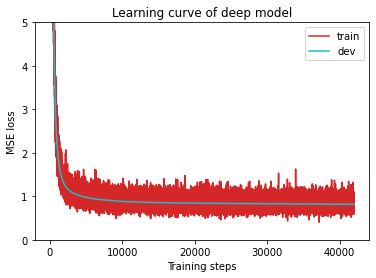

In [17]:
plot_learning_curve(model_loss_record, title='deep model')

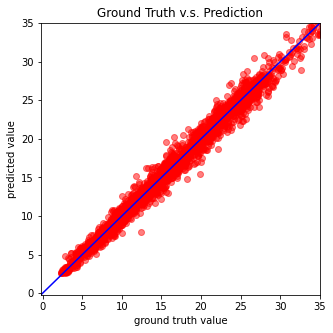

In [18]:
del model
model = NeuralNet(dv_set.dataset[0][0].shape[0]).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [19]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
